In [52]:
%matplotlib inline
import pandas as pd
import numpy as np
import pymongo
import pandas as pd
from textblob import TextBlob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from math import log1p, isnan
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import os
import re

In [53]:
dbcon = pymongo.MongoClient(os.getenv('BAILY_MONGO_URI'))
social_posts_fields = ["text", "tag", "video_title","video_views_total", "views_per_hour"]
social_posts = pd.DataFrame(list(dbcon['chatbox-dev'].social_posts.find()), columns=social_posts_fields)
print social_posts.count()
social_posts[13000:13338]

text                 13323
tag                  13323
video_title          13323
video_views_total    13323
views_per_hour       13320
dtype: int64


,text,tag,video_title,video_views_total,views_per_hour
13000,"DUTCH-BATTLEFIELD""PROD BY DJ RICH"" Adblock Plu...",Adblock Plus,"DUTCH-BATTLEFIELD""PROD BY DJ RICH""",20,0.000427
13001,Dj Delz Visits Dblocks Styles P & Jadakiss Jui...,Adblock Plus,Dj Delz Visits Dblocks Styles P & Jadakiss Jui...,33,0.004693
13002,[PDF] 52 Series: Things to Try Once in Your Li...,#ThingsToTryJustOnce,[PDF] 52 Series: Things to Try Once in Your Li...,0,0.000000
13003,[ENG] 160630 KCON 2016 NY Rap Monster MC Cuts ...,Harambe McHarambeface,[ENG] 160630 KCON 2016 NY Rap Monster MC Cuts,2666,1.394654
13004,"New Book Tuesdays with Morrie: An Old Man, a Y...",#TuesdayMotivation,"New Book Tuesdays with Morrie: An Old Man, a Y...",0,0.000000
13005,Dj Delz Visits Dblocks Styles P & Jadakiss Jui...,Adblock Plus,Dj Delz Visits Dblocks Styles P & Jadakiss Jui...,33,0.004693
13006,ＭＣ① / AAA 5th Anniversary LIVE 2010 横浜アリーナ Har...,Harambe McHarambeface,ＭＣ① / AAA 5th Anniversary LIVE 2010 横浜アリーナ,8511,2.163779
13007,[PDF] Fat Tuesday Fricassee (Biscuit Bowl Food...,#TuesdayMotivation,[PDF] Fat Tuesday Fricassee (Biscuit Bowl Food...,0,0.000000
13008,"New Book Tuesdays with Morrie: An Old Man, a Y...",#TuesdayMotivation,"New Book Tuesdays with Morrie: An Old Man, a Y...",0,0.000000
13009,"Gaiteiro Popular ""Os Katembas"" - 10 anos iOS 1...",iOS 10,"Gaiteiro Popular ""Os Katembas"" - 10 anos",1,0.000401


In [54]:
black_list = [
    'pdf',
    'download',
    'ebook',
    'online',
    'read',
    'full movie',
    'book',
    'buy',
    'fuck',
    'cams',
    'webcam',
    'boob',
    'sex',
    'follow',
]

regexes = [re.compile(' ' + word + ' ', re.IGNORECASE) for word in black_list]

In [55]:
url = r'([\da-z\.-]+\.[a-z\.]{2,6})'

index = 0
has_blacklist_words = []
title_lengths = []
title_caps_percents = []
link_counts = []
subjectivities = []
polarities = []
view_logs = []

texts = []

for title in social_posts['video_title']:
    
    has_b = False
    for regex in regexes:
        if regex.search(title):
            has_b = True
            
    has_blacklist_words.append(has_b)
    texts.append(title)
            
    title_lengths.append(len(title))
    caps_count = float(sum(1 for c in title if c.isupper()))
    title_caps_percents.append(caps_count/float(len(title)))
    link_counts.append(len(re.findall(url, title)))
    
    tb = TextBlob(title)
    subjectivities.append(tb.sentiment.subjectivity)
    polarities.append(tb.sentiment.polarity)
    
    lp = log1p(social_posts['video_views_total'][index])
    if not isnan(lp):
        view_logs.append(lp/10)
    else:
        view_logs.append(0)
            
    index = index + 1
    
social_posts['has_blacklist_words'] = has_blacklist_words
social_posts['title_length'] = title_lengths
social_posts['title_caps_percent'] = title_caps_percents
social_posts['link_count'] = link_counts
social_posts['subjectivity'] = subjectivities
social_posts['polarity'] = polarities
social_posts['views_score'] = view_logs


social_posts.sort_values('views_per_hour',ascending=False).head()

,text,tag,video_title,video_views_total,views_per_hour,has_blacklist_words,title_length,title_caps_percent,link_count,subjectivity,polarity,views_score
5443,New Punjabi Songs 2015 I Honey Raaj I Lagdi Ka...,A.I.,New Punjabi Songs 2015 I Honey Raaj I Lagdi Ka...,1843831,261.824814,False,81,0.17284,0,0.60303,0.257576,1.442736
8569,Brown Sugar I SAM ASH I Mannan Music I Latest ...,Antonio Brown,Brown Sugar I SAM ASH I Mannan Music I Latest ...,749546,141.554023,False,64,0.25000,0,0.90000,0.500000,1.352722
8728,Brown Sugar I SAM ASH I Mannan Music I Latest ...,Antonio Brown,Brown Sugar I SAM ASH I Mannan Music I Latest ...,749548,141.553937,False,64,0.25000,0,0.90000,0.500000,1.352723
8748,Brown Sugar I SAM ASH I Mannan Music I Latest ...,Antonio Brown,Brown Sugar I SAM ASH I Mannan Music I Latest ...,749548,141.553924,False,64,0.25000,0,0.90000,0.500000,1.352723
8798,Brown Sugar I SAM ASH I Mannan Music I Latest ...,Antonio Brown,Brown Sugar I SAM ASH I Mannan Music I Latest ...,749548,141.553900,False,64,0.25000,0,0.90000,0.500000,1.352723


In [56]:
social_posts.corr()

,video_views_total,views_per_hour,has_blacklist_words,title_length,title_caps_percent,link_count,subjectivity,polarity,views_score
video_views_total,1.000000,0.609378,-0.029781,0.000064,-0.006599,-0.007165,-0.011691,-0.013435,0.276003
views_per_hour,0.609378,1.000000,-0.044520,0.054363,-0.014674,-0.000336,0.023698,0.004966,0.334924
has_blacklist_words,-0.029781,-0.044520,1.000000,0.204369,0.056068,-0.028324,0.135401,0.056877,-0.236055
title_length,0.000064,0.054363,0.204369,1.000000,-0.081170,0.018911,0.264645,0.113923,-0.115342
title_caps_percent,-0.006599,-0.014674,0.056068,-0.081170,1.000000,-0.048782,0.017383,0.023101,-0.027850
link_count,-0.007165,-0.000336,-0.028324,0.018911,-0.048782,1.000000,-0.028243,-0.013344,0.023449
subjectivity,-0.011691,0.023698,0.135401,0.264645,0.017383,-0.028243,1.000000,0.398789,-0.103231
polarity,-0.013435,0.004966,0.056877,0.113923,0.023101,-0.013344,0.398789,1.000000,-0.079717
views_score,0.276003,0.334924,-0.236055,-0.115342,-0.027850,0.023449,-0.103231,-0.079717,1.000000


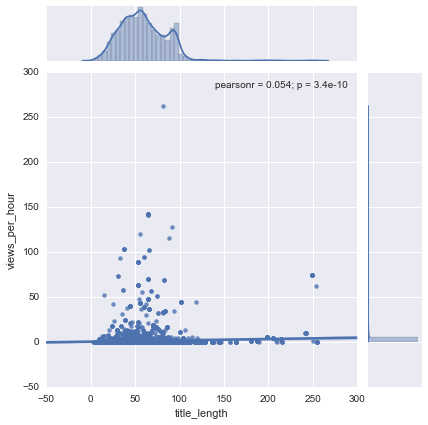

In [57]:
sns.jointplot(y='views_per_hour', x='title_length', data=social_posts, kind="reg")

In [68]:
views_level = []

for i in range(len(social_posts)):
    if(social_posts.ix[i].views_per_hour > 1.8):
        views_level.append(13)
    elif(social_posts.ix[i].views_per_hour > 1.4):
        views_level.append(12)
    elif(social_posts.ix[i].views_per_hour > 1.2):
        views_level.append(11)
    elif(social_posts.ix[i].views_per_hour > 1):
        views_level.append(10)
    elif(social_posts.ix[i].views_per_hour > 0.8):
        views_level.append(9)
    elif(social_posts.ix[i].views_per_hour > 0.7):
        views_level.append(8)
    elif(social_posts.ix[i].views_per_hour > 0.6):
        views_level.append(7)
    elif(social_posts.ix[i].views_per_hour > 0.5):
        views_level.append(6)
    elif(social_posts.ix[i].views_per_hour > 0.4):
        views_level.append(5)
    elif(social_posts.ix[i].views_per_hour > 0.3):
        views_level.append(4)
    elif(social_posts.ix[i].views_per_hour > 0.2):
        views_level.append(3)
    elif(social_posts.ix[i].views_per_hour > 0.1):
        views_level.append(2)
    elif(social_posts.ix[i].views_per_hour > 0.05):
        views_level.append(1)
    else:
        views_high.append(0)


social_posts.views_level = views_level

In [59]:
m1 = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', LogisticRegression(penalty='l1', C=10))
])
m1.fit(social_posts[500:]['text'], social_posts[500:]['views_level'])

print("Classification accuracy on training data: %.2f" % m1.score(texts[:500], views_high[:500]))

Classification accuracy on training data: 0.90


In [65]:
vec, clf = m1.named_steps['vectorizer'], m1.named_steps['classifier']
coefs = pd.Series(clf.coef_[0], index=vec.get_feature_names())
print("\n20 most discriminating words:")
print(coefs[coefs.abs().sort_values(ascending=False).index][:20])


20 most discriminating words:
northkorea          32.641267
mytwitterbotname    29.296381
classictvamovie     27.511949
apes                27.313238
farmingcelebs       26.698450
urdu                26.173028
ayeshablogger       25.997350
monkeys             24.258313
lazizinews          23.593017
savenelly           23.334111
goff                23.237928
samsung             23.188391
keenan              23.175142
married             22.476156
weirdgamestv        22.442677
2bntxi3             21.811765
pdf                -21.777769
pixar               21.026375
2cityku             19.845929
http               -19.685984
dtype: float64


In [67]:
from sklearn.externals import joblib

joblib.dump({'views_level': m1}, 'models', compress=9)

['models']